In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np

# Use this script to gather results inside one subdirectory and plot them. Be sure to always to always start the script from the directory where the '0io', '1io', '2io' etc. directories are located.

In [64]:

# Define the base directory where the CSV files are located
# base_dir = '/home/fott/UniPPS/projekt/messungen/cp/r2b5/12m/n4joint/'  # Replace this with the actual path
base_dir = '/home/fott/UniZeug/projekt/projekt/messungen/io/r2b5/12m/n1/'  # Replace this with the actual path

# Initialize a list to hold the total averages and their corresponding process counts
data = []

# Iterate over the folders for IO and checkpoints
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    file_data = pd.DataFrame()
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Iterate over files in the directory
        for filename in os.listdir(folder_path):
            if filename.endswith('.csv'):
                csv_path = os.path.join(folder_path, filename)
                
                # Read the CSV file
                try:
                    df = pd.read_csv(csv_path, index_col=0)

                    filetype = 'io' if 'io' in filename else 'checkpoints' if 'checkpoints' in filename else 'workers'

                    total_avg = df.loc['total', 'total avg (s)'] if filename == 'timer_report_workers.csv' else 0
                    wrt_output_avg = df.loc['wrt_output', 'total avg (s)'] if not filename == 'timer_report_checkpoints.csv' else 0
                    wrt_restart_avg = df.loc['write_restart', 'total avg (s)'] if not filename == 'timer_report_io.csv' else 0

                    time_data = pd.Series((total_avg, wrt_output_avg, wrt_restart_avg), index=['total_avg', 'wrt_output_avg', 'wrt_restart_avg'], name=filetype)

                    # Append the value with the number of processes (extracted from the folder name)
                    file_data = pd.concat((file_data, time_data.to_frame().T), ignore_index=False)
                except Exception as e:
                    print(f'Error reading {csv_path}: {e}')

        data.append((re.sub(r'[a-z]+', '', folder), file_data))

        print(file_data.head())

         total_avg  wrt_output_avg  wrt_restart_avg
workers   1817.599          456.26            0.002
         total_avg  wrt_output_avg  wrt_restart_avg
workers    1427.72          15.389            0.002
io            0.00         147.611            0.000
         total_avg  wrt_output_avg  wrt_restart_avg
workers    1453.51          62.075            0.003
io            0.00         811.806            0.000
         total_avg  wrt_output_avg  wrt_restart_avg
workers   1426.976          30.584            0.003
io           0.000         361.391            0.000
         total_avg  wrt_output_avg  wrt_restart_avg
workers   1571.299            3.46            0.002
io           0.000           25.10            0.000
         total_avg  wrt_output_avg  wrt_restart_avg
workers   1466.152           3.366            0.003
io           0.000          53.587            0.000
         total_avg  wrt_output_avg  wrt_restart_avg
workers   1848.764           4.055            0.002
io          

In [65]:
# Create a DataFrame from the collected data
results = pd.DataFrame(data, columns=['# processes', 'data'])

# Convert the 'Processes' to a categorical variable for proper sorting in the plot
results.sort_values('# processes', inplace=True, key=lambda x: x.astype(int))
results['# processes'] = results['# processes'].astype(str)

# results.head()
print(results['data'])
# print(data.head())

0             total_avg  wrt_output_avg  wrt_restar...
2             total_avg  wrt_output_avg  wrt_restar...
3             total_avg  wrt_output_avg  wrt_restar...
1             total_avg  wrt_output_avg  wrt_restar...
5             total_avg  wrt_output_avg  wrt_restar...
4             total_avg  wrt_output_avg  wrt_restar...
6             total_avg  wrt_output_avg  wrt_restar...
Name: data, dtype: object


In [66]:
# Read the CSV file "get_write_speed.csv"
write_speed_df = pd.read_csv(os.path.join(base_dir, 'get_write_speed.csv'), index_col=0, header=0)

# Display the first few rows of the dataframe
print(write_speed_df.head())

                 Get MB/s avg  Write MB/s avg
# dedicated PEs                              
0io                  0.000000        0.000000
1io               3256.111037      276.258301
2io               3062.782425      326.587555
4io               3371.079753      400.624473
8io               3819.706763      539.340121


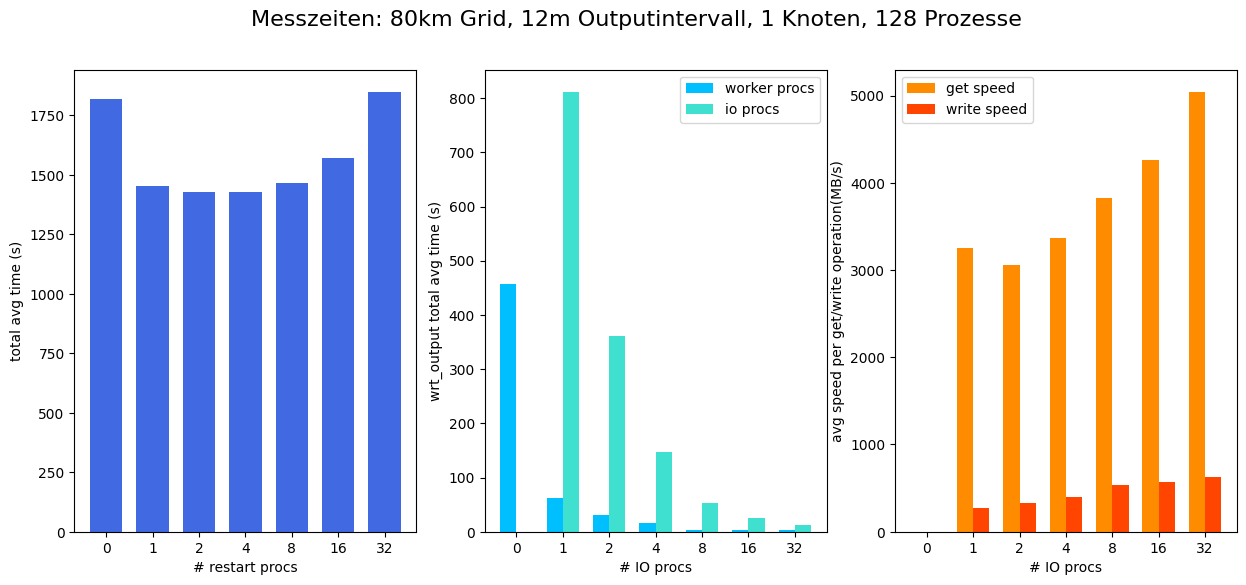

In [67]:

# Plotting the data

total = results['data'].apply(lambda x: x['total_avg']).fillna(0)
# print(total)
wrt_output = results['data'].apply(lambda x: x['wrt_output_avg']).fillna(0)
# print(wrt_output)
wrt_restart = results['data'].apply(lambda x: x['wrt_restart_avg']).fillna(0)
# print(wrt_restart)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
bar_width = 0.35

fig.suptitle('Messzeiten: 80km Grid, 12m Outputintervall, 1 Knoten, 128 Prozesse', fontsize=16)

ax[0].bar(results['# processes'], total['workers'], color='royalblue', width=bar_width*2)
ax[0].set_xlabel('# restart procs')
ax[0].set_ylabel('total avg time (s)')

x = np.arange(len(results['# processes']))

# ax[1].bar(x - bar_width/2, wrt_restart['workers'], color='blueviolet', width=bar_width)
# ax[1].bar(x + bar_width/2 , wrt_restart['checkpoints'], color='indigo', width=bar_width)
# ax[1].bar(results['# processes'], wrt_restart['workers'], color='blueviolet', width=bar_width*2)
# ax[1].legend(['worker procs', 'restart procs'])
# ax[1].set_xticks(x, results['# processes'])
# ax[1].set_xlabel('# restart procs')
# ax[1].set_ylabel('wrt_restart total avg time (s)')

ax[1].bar(x - bar_width/2, wrt_output['workers'], color='deepskyblue', width=bar_width)
ax[1].bar(x + bar_width/2 , wrt_output['io'], color='turquoise', width=bar_width)
ax[1].legend(['worker procs', 'io procs'])
ax[1].set_xticks(x, results['# processes'])
ax[1].set_xlabel('# IO procs')
ax[1].set_ylabel('wrt_output total avg time (s)')

ax[2].bar(x - bar_width/2, write_speed_df['Get MB/s avg'], color='darkorange', width=bar_width)
ax[2].bar(x + bar_width/2 , write_speed_df['Write MB/s avg'], color='orangered', width=bar_width)
ax[2].legend(['get speed', 'write speed'])
ax[2].set_xticks(x, results['# processes'])
ax[2].set_xlabel('# IO procs')
ax[2].set_ylabel('avg speed per get/write operation(MB/s)')


plt.savefig(base_dir + 'messzeiten.png', format='png', dpi=300, )

plt.show()